# Setup and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

import scipy.integrate as integrate
from scipy.integrate import simpson
from scipy.integrate import cumulative_trapezoid
import scipy.sparse
from scipy.sparse import lil_matrix
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import factorized
from scipy.linalg import cho_factor, cho_solve
from scipy.interpolate import CubicSpline

import cvxpy as cp
from numpy.linalg import lstsq

# FEM for the system PDE and Sensitivity coefficients

## Simulation Parameters

In [2]:
# Time parameters
T = 1.0             # Final time
dt = 0.001          # Time step
nt = int(T / dt)    # Number of time steps

# Unknown system parameters
theta1, theta2, theta3, theta4, theta5 = 0.02, 0.01, 0.01, 0.5, 0.5

# Reaction rate
kappa = 0.2

# Create mesh
nx, ny = 100, 100
hx, hy = 1.0 / nx, 1.0 / ny

X, Y = np.meshgrid(np.linspace(0, 1, nx+1), np.linspace(0, 1, ny+1))
points = np.vstack([X.ravel(), Y.ravel()]).T

num_nodes = points.shape[0]  # Number of mesh points

# Map (i,j) grid index to global node index
node_index = lambda i, j: j * (nx + 1) + i

# Build triangles: split each square into two triangles
triangles = []
for j in range(ny):
    for i in range(nx):
        n0 = node_index(i, j)
        n1 = node_index(i+1, j)
        n2 = node_index(i, j+1)
        n3 = node_index(i+1, j+1)
        triangles.append([n0, n1, n3])  # lower-right triangle
        triangles.append([n0, n3, n2])  # upper-left triangle
triangles = np.array(triangles)

# area of each triangle
area = 1/2*hx**2


In [3]:
# Compute gradients of basis functions (∇φ_i)

for tri in triangles:

    p = points[tri]  # 3x2 array

    # Using inverse of affine map
    B = np.array([
        [p[1][0] - p[0][0], p[2][0] - p[0][0]],
        [p[1][1] - p[0][1], p[2][1] - p[0][1]]
    ])
    invB = np.linalg.inv(B)

    # Gradients of reference triangle shape functions
    grad_ref = np.array([[-1, -1], [1, 0], [0, 1]])  # ∇φ1, ∇φ2, ∇φ3
    grads = grad_ref @ invB.T  # ∇φ_i in real triangle

## Functions of the system PDE

In [4]:
# Spatially-varying diffusion coefficient d(x,y)
def diffusion_coeff(x,y):
  return theta1 + theta2*(x-theta4)**2 + theta3*(y-theta5)**2


In [5]:
# Partial derivatives of the diffusion coefficient d(x,y)

def par_diffusion_1(x,y):
  return 1

def par_diffusion_2(x,y):
  return (x - theta4)**2

def par_diffusion_3(x,y):
  return (y - theta5)**2

def par_diffusion_4(x,y):
  return 2*theta4 - 2*theta2*x

def par_diffusion_5(x,y):
  return 2*theta5 - 2*theta3*y

In [6]:
def velocity_field(x, y, t=1.0): # two rotating vortices

    cx1, cy1 = 0.25 + 0.05*np.sin(2*np.pi*t), 0.8
    cx2, cy2 = 1.00 , 0.2 + 0.05*np.cos(2*np.pi*t)
    r1_sq = (x - cx1)**2 + (y - cy1)**2
    r2_sq = (x - cx2)**2 + (y - cy2)**2
    sigma = 0.35

    A = 2 * np.cos(2*np.pi*t)
    vx = A * (-(y - cy1)) * np.exp(-r1_sq / sigma**2) + \
        (-A) * (-(y - cy2)) * np.exp(-r2_sq / sigma**2)
    vy = A * (x - cx1) * np.exp(-r1_sq / sigma**2) + \
        (-A) * (x - cx2) * np.exp(-r2_sq / sigma**2)

    return vx, vy

In [7]:
def velocity_field_faster(x, y, t=1.0): # two rotating vortices, but faster transport

    cx1, cy1 = 0.25 + 0.05*np.sin(2*np.pi*t), 0.8
    cx2, cy2 = 1.00 , 0.2 + 0.05*np.cos(2*np.pi*t)
    r1_sq = (x - cx1)**2 + (y - cy1)**2
    r2_sq = (x - cx2)**2 + (y - cy2)**2
    sigma = 0.35

    A = 2 * np.cos(2*np.pi*t)
    vx = A * (-(y - cy1)) * np.exp(-r1_sq / sigma**2) + \
        (-A) * (-(y - cy2)) * np.exp(-r2_sq / sigma**2)
    vy = A * (x - cx1) * np.exp(-r1_sq / sigma**2) + \
        (-A) * (x - cx2) * np.exp(-r2_sq / sigma**2)

    return 2*vx, 2*vy

In [8]:
def velocity_field_2(x, y, U_max=1.0): # simpler wind field
    """
    Wind blowing from left to right with vertical shear.
    Velocity increases linearly with height (y).

    v(x,y) = (U_max * y, 0)
    """
    vx = U_max * y
    vy = np.zeros_like(y)
    return vx, vy


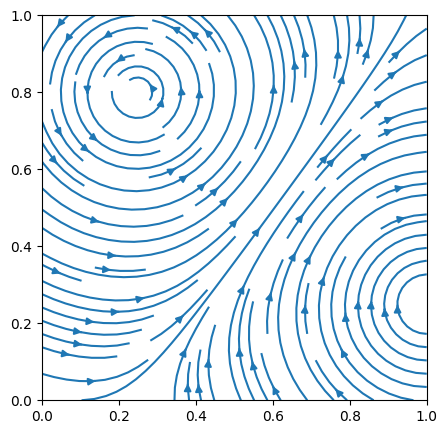

In [9]:
U, V = velocity_field(X,Y)

# Plotting

fig, ax = plt.subplots(figsize=(5,5))
ax.streamplot(X, Y, U, V)
# plt.title("Time t = 0.0")
# plt.xlabel("x_1")
# plt.ylabel("x_2")
plt.axis("square")
plt.show()

## Assemble the matrices

### Assemble mass matrix

For each triangle T_e, define:

M_ij(e)=∫T_e ϕi⋅ϕj dx


In [10]:

row, col, data = [], [], []

for tri in triangles:

    # Local mass matrix
    m_local = (area / 12.0) * np.array([
        [2, 1, 1],
        [1, 2, 1],
        [1, 1, 2]
    ])

    # Add to global matrix
    for i_local, i_global in enumerate(tri):
        for j_local, j_global in enumerate(tri):
            row.append(i_global)
            col.append(j_global)
            data.append(m_local[i_local, j_local])

# Create sparse matrix
M = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes)).tocsr()


### Assemble stiffness matrix (Diffusion term)



For each triangle, define:

K ij(e)=∫T_e d(x) ∇ϕi⋅∇ϕj dx

On a triangle T_e​ with nodes P0,P1,P2​, compute the gradients of basis functions ∇ϕi using barycentric coordinates.

The gradient of a P1 basis function ϕi​ is constant on each triangle.

In [11]:
# Triangle vertex coordinates
# p0, p1, p2 = points[tri[0]], points[tri[1]], points[tri[2]]


In [12]:

row, col, data = [], [], []

for tri in triangles:

    # Local stiffness matrix
    k_local = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            k_local[i, j] = area * np.dot(grads[i], grads[j])

    centroid = np.mean(points[tri], axis=0)
    d_val = diffusion_coeff(centroid[0], centroid[1])

    # scale k_local:
    k_local *= d_val

    # Add to global stiffness matrix
    for i_local, i_global in enumerate(tri):
        for j_local, j_global in enumerate(tri):
            row.append(i_global)
            col.append(j_global)
            data.append(k_local[i_local, j_local])

# Assemble sparse global stiffness matrix
K = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes)).tocsr()


### Diffusion term  with the derivative of the parameters

In [13]:
K_params = [] # list of the 5 partial derivatives of the diffusion term

In [14]:
# K_1

row, col, data = [], [], []

for tri in triangles:

    # Local stiffness matrix
    k_local = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            k_local[i, j] = area * np.dot(grads[i], grads[j])

    ''' par_diffusion_1 is constant at 1, so no need to scale k_local
    centroid = np.mean(points[tri], axis=0)
    d_val = par_diffusion_1(centroid[0], centroid[1])

    # scale k_local:
    k_local *= d_val
    '''

    # Add to global stiffness matrix
    for i_local, i_global in enumerate(tri):
        for j_local, j_global in enumerate(tri):
            row.append(i_global)
            col.append(j_global)
            data.append(k_local[i_local, j_local])

# Assemble sparse global stiffness matrix
K_1 = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes)).tocsr()

K_params.append(K_1.copy())

In [15]:
# K_2

row, col, data = [], [], []

for tri in triangles:

    # Local stiffness matrix
    k_local = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            k_local[i, j] = area * np.dot(grads[i], grads[j])

    centroid = np.mean(points[tri], axis=0)
    d_val = par_diffusion_2(centroid[0], centroid[1])

    # scale k_local:
    k_local *= d_val

    # Add to global stiffness matrix
    for i_local, i_global in enumerate(tri):
        for j_local, j_global in enumerate(tri):
            row.append(i_global)
            col.append(j_global)
            data.append(k_local[i_local, j_local])

# Assemble sparse global stiffness matrix
K_2 = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes)).tocsr()

K_params.append(K_2.copy())

In [16]:
# K_3

row, col, data = [], [], []

for tri in triangles:

    # Local stiffness matrix
    k_local = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            k_local[i, j] = area * np.dot(grads[i], grads[j])

    centroid = np.mean(points[tri], axis=0)
    d_val = par_diffusion_3(centroid[0], centroid[1])

    # scale k_local:
    k_local *= d_val

    # Add to global stiffness matrix
    for i_local, i_global in enumerate(tri):
        for j_local, j_global in enumerate(tri):
            row.append(i_global)
            col.append(j_global)
            data.append(k_local[i_local, j_local])

# Assemble sparse global stiffness matrix
K_3 = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes)).tocsr()

K_params.append(K_3.copy())

In [17]:
# K_4

row, col, data = [], [], []

for tri in triangles:

    # Local stiffness matrix
    k_local = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            k_local[i, j] = area * np.dot(grads[i], grads[j])

    centroid = np.mean(points[tri], axis=0)
    d_val = par_diffusion_4(centroid[0], centroid[1])

    # scale k_local:
    k_local *= d_val

    # Add to global stiffness matrix
    for i_local, i_global in enumerate(tri):
        for j_local, j_global in enumerate(tri):
            row.append(i_global)
            col.append(j_global)
            data.append(k_local[i_local, j_local])

# Assemble sparse global stiffness matrix
K_4 = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes)).tocsr()

K_params.append(K_4.copy())

In [18]:
# K_5

row, col, data = [], [], []

for tri in triangles:

    # Local stiffness matrix
    k_local = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            k_local[i, j] = area * np.dot(grads[i], grads[j])

    centroid = np.mean(points[tri], axis=0)
    d_val = par_diffusion_5(centroid[0], centroid[1])

    # scale k_local:
    k_local *= d_val

    # Add to global stiffness matrix
    for i_local, i_global in enumerate(tri):
        for j_local, j_global in enumerate(tri):
            row.append(i_global)
            col.append(j_global)
            data.append(k_local[i_local, j_local])

# Assemble sparse global stiffness matrix
K_5 = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes)).tocsr()

K_params.append(K_5.copy())

### Assemble advection matrix (Advection term)

For each triangle, define:

C_ij(e)=∫T_e (v(x)⋅∇ϕj)ϕi dx

On a triangle T_e​ with nodes P0,P1,P2​, compute the gradients of basis functions ∇ϕi using barycentric coordinates.

The gradient of a P1 basis function ϕi​ is constant on each triangle.


v_func(x, y): velocity field returning a 2D vector.

The 1/3 factor assumes φ_i is approximately constant (= 1/3) over the triangle when integrating.

This is a basic Galerkin (non-upwinded) method. For stabilization, SUPG or upwinding can be applied in high Peclet flows.


In [19]:

row, col, data = [], [], []

for tri in triangles:
    indices = tri

    # Evaluate velocity at triangle centroid
    centroid = np.mean(points[indices], axis=0)
    vx, vy = velocity_field(centroid[0], centroid[1])
    v = np.array([vx, vy])

    # Local advection matrix
    a_local = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            a_local[i, j] = area * np.dot(v, grads[j]) * (1/3)  # φ_i ≈ 1/3 on triangle

    # Assemble into global matrix
    for i_local, i_global in enumerate(indices):
        for j_local, j_global in enumerate(indices):
            row.append(i_global)
            col.append(j_global)
            data.append(a_local[i_local, j_local])

# Create sparse matrix
num_nodes = points.shape[0]
C = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes)).tocsr()

'''
could add SUPG stabilization in the streamline direction.
'''

'\ncould add SUPG stabilization in the streamline direction.\n'

## Assemble linear system

In [20]:
# Gaussian initial conditions
def gaussian_ic(points, center=(0.5, 0.5), sigma=0.05):
    x, y = points[:, 0], points[:, 1]
    xc, yc = center
    return np.exp(-((x - xc)**2 + (y - yc)**2) / (2 * sigma**2))

u = gaussian_ic(points)

# matrix of sensitivity coefficients
G = np.zeros((5, num_nodes))


# ---- ASSEMBLE R ----
R = kappa * M

# ---- TIME STEPPING MATRICES ----
LHS = M + dt * (C + K + R)

# LU factorization for performance
LHS_solver = factorized(LHS.tocsr())

# tri = Triangulation(points[:, 0], points[:, 1], triangles) # need for plotting


# ---- TIME LOOP ----
solutions = [u.copy()]
sensitivities = [G.copy()]

for n in range(nt): # nt
    # solve system PDE
    rhs = M @ u
    u_new = LHS_solver(rhs)           # LU-based solve
    u = u_new

    # solve sensitivity equations
    for i in range(5):
        rhs_g = M @ G[i,:] - dt * (K_params[i] @ u)
        g_new = LHS_solver(rhs_g)  # LU-based solve
        G[i,:] = g_new

    if n % 5 == 4:
        solutions.append(u.copy())
        sensitivities.append(G.copy())    # 201 solutions are saved

    if n % 50 == 49:
        print(f"Step {n+1}/{nt}")
    '''
    # plotting selected time steps
    if n % 200 == 0:
        plt.figure()
        plt.tricontourf(tri, u, levels=50)
        plt.colorbar()
        plt.title(f"Time t = {n/nt:.2f}")
        plt.show()
    '''

/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Step 50/1000
Step 100/1000
Step 150/1000
Step 200/1000
Step 250/1000
Step 300/1000
Step 350/1000
Step 400/1000
Step 450/1000
Step 500/1000
Step 550/1000
Step 600/1000
Step 650/1000
Step 700/1000
Step 750/1000
Step 800/1000
Step 850/1000
Step 900/1000
Step 950/1000
Step 1000/1000


In [21]:
# G[:,1].shape, G[1,boundary_nodes].shape
# LHS_BC.toarray()[:,:]
# G[1,boundary_nodes]
# LHS_BC @ G[4,:] == rhs_g_bc
# for i in range(5):
#  print(np.isclose(G[i,boundary_nodes],0))

## Visualize

In [22]:
tri = Triangulation(points[:, 0], points[:, 1], triangles)

# plt.figure()
# plt.tricontourf(tri, solutions[0], levels=50) # to plot sensitivities, replace by u (time 1.0, param 3)
# plt.colorbar()
# plt.title(f"Time t = {n/nt:.2f}")
# plt.show()

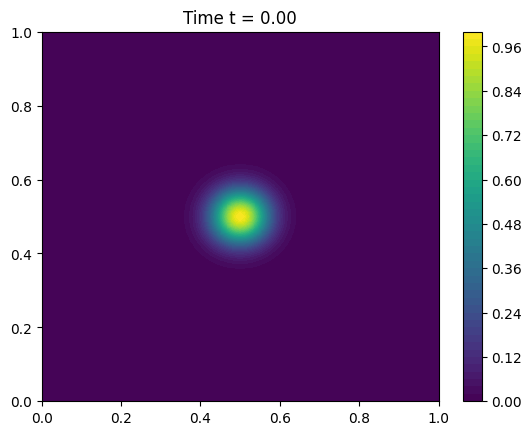

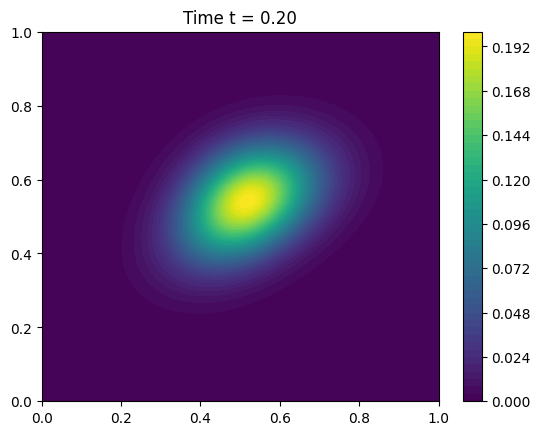

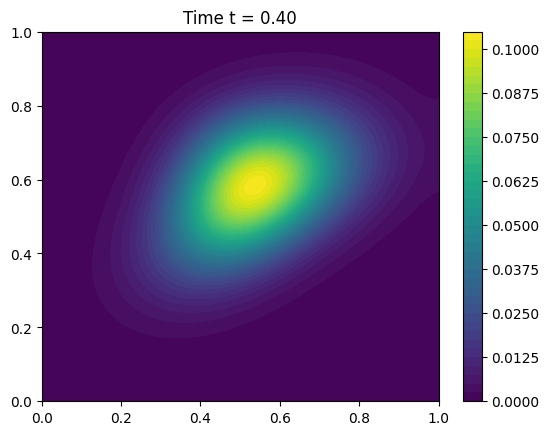

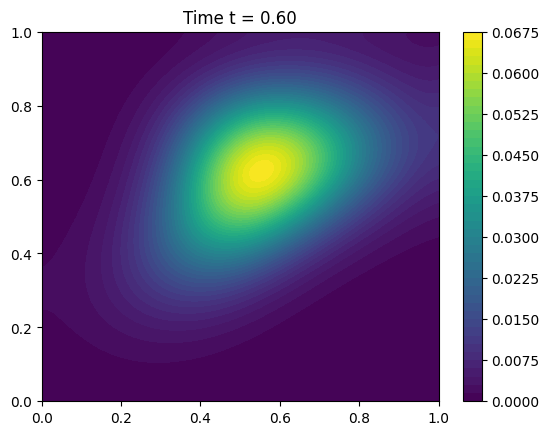

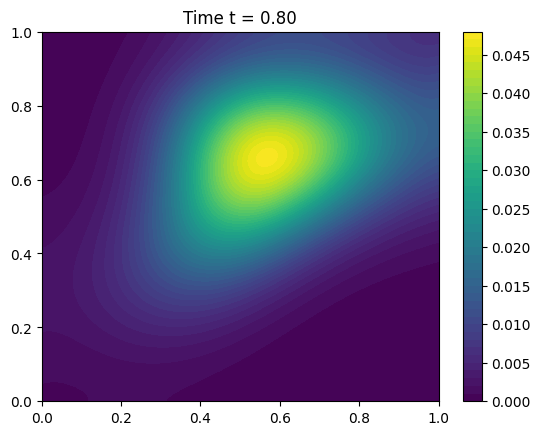

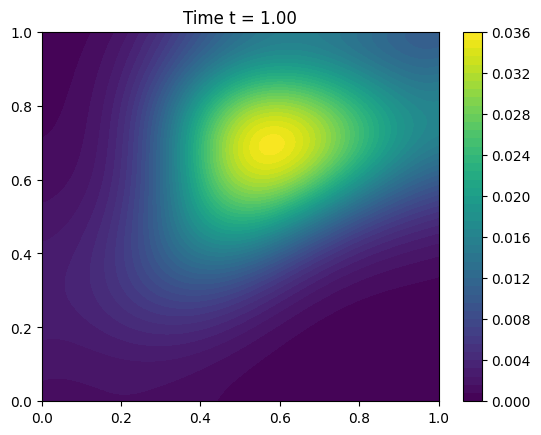

In [23]:
len_solutions = len(solutions)
for t_spep in range(0,len_solutions , 40):
    plt.figure()
    plt.tricontourf(tri, solutions[t_spep], levels=50) # to plot sensitivities, replace by u (time 1.0, param 3)
    plt.colorbar()
    plt.title(f"Time t = {t_spep/len_solutions:.2f}")
    plt.show()

# Spline interpolation using Scipy

## Define tricubic functions


In [24]:
#--------------------------------------------
# Define 1D Hermite spline and tricubic functions

def compute_second_derivatives(x, y, z, f):
    """
    Compute second derivatives along each axis using natural cubic splines.

    Parameters:
        x (1D array): Shape (nx,), grid along x-axis.
        y (1D array): Shape (ny,), grid along y-axis.
        z (1D array): Shape (nz,), grid along z-axis.
        f (3D array): Shape (nx, ny, nz), grid values of f(x,y,z).

    Returns:
        Mx, My, Mz (3D arrays): Each of shape (nx, ny, nz), second derivatives
        of f along x, y, and z respectively.
    """
    nx, ny, nz = f.shape
    Mx = np.zeros_like(f)
    My = np.zeros_like(f)
    Mz = np.zeros_like(f)

    # Along x‐lines
    for j in range(ny):
        for k in range(nz):
            cs = CubicSpline(x, f[:, j, k], bc_type='natural')
            Mx[:, j, k] = cs.derivative(2)(x)

    # Along y‐lines
    for i in range(nx):
        for k in range(nz):
            cs = CubicSpline(y, f[i, :, k], bc_type='natural')
            My[i, :, k] = cs.derivative(2)(y)

    # Along z‐lines
    for i in range(nx):
        for j in range(ny):
            cs = CubicSpline(z, f[i, j, :], bc_type='natural')
            Mz[i, j, :] = cs.derivative(2)(z)

    return Mx, My, Mz


def hermite1d(v0, v1, m0, m1, h, t):
    """
    Perform 1D cubic Hermite interpolation.

    Parameters:
        v0, v1 (float): Function values at interval endpoints.
        m0, m1 (float): Second derivatives at endpoints.
        h (float): Interval length.
        t (float): Normalized position in [0, 1].

    Returns:
        float: Interpolated value.
    """
    h2 = h*h
    term0 = (1 - t) * v0 + t * v1
    term1 = (h2/6.0) * (((1 - t)*((1 - t)**2 - 1)) * m0 + (t*(t**2 - 1)) * m1)
    return term0 + term1

def tricubic_interp(x, y, z, f, Mx, My, Mz, xi, yi, zi):
    """
    Evaluate the tricubic spline at an off-grid point (xi, yi, zi).

    Parameters:
        x, y, z (1D arrays): Grid axes.
        f (3D array): Shape (nx, ny, nz), function values on grid.
        Mx, My, Mz (3D arrays): Shape (nx, ny, nz), second derivatives.
        xi, yi, zi (float): Coordinates of evaluation point.

    Returns:
        float: Interpolated function value at (xi, yi, zi).
    """
    i = np.searchsorted(x, xi) - 1
    j = np.searchsorted(y, yi) - 1
    k = np.searchsorted(z, zi) - 1
    i = np.clip(i, 0, len(x)-2)
    j = np.clip(j, 0, len(y)-2)
    k = np.clip(k, 0, len(z)-2)

    dx = x[i+1] - x[i]
    dy = y[j+1] - y[j]
    dz = z[k+1] - z[k]
    tx = (xi - x[i]) / dx
    ty = (yi - y[j]) / dy
    tz = (zi - z[k]) / dz

    # Interpolate along x
    F = np.zeros((2,2))
    for jj in (0,1):
        for kk in (0,1):
            v0 = f[i  , j+jj, k+kk]
            v1 = f[i+1, j+jj, k+kk]
            m0 = Mx[i  , j+jj, k+kk]
            m1 = Mx[i+1, j+jj, k+kk]
            F[jj,kk] = hermite1d(v0, v1, m0, m1, dx, tx)

    # Interpolate along y
    G = np.zeros(2)
    for kk in (0,1):
        v0 = F[0,kk]
        v1 = F[1,kk]
        m0 = My[i, j  , k+kk]
        m1 = My[i, j+1, k+kk]
        G[kk] = hermite1d(v0, v1, m0, m1, dy, ty)

    # Interpolate along z
    v0 = G[0]
    v1 = G[1]
    m0 = Mz[i, j,   k  ]
    m1 = Mz[i, j,   k+1]
    return hermite1d(v0, v1, m0, m1, dz, tz)

### First derivatives of the spline wrt the space coordinates

In [25]:
# Compute the first derivatives of the spline wrt the space coordinates

def partial_x(x, y, z, f, Mx, xi, yi, zi):
    """
    Evaluate partial derivative ∂f/∂x at an off-grid x-point.

    Parameters:
        x, y, z (1D arrays): Grid axes.
        f (3D array): Shape (nx, ny, nz), function values on grid.
        Mx, My (3D arrays): Shape (nx, ny, nz), second derivatives.
        xi, yi, zi (float): Coordinates of evaluation point.
    Returns:
        float: Approximation to ∂f/∂x at (xi, yj, zk).
    """
    i = np.searchsorted(x, xi) - 1
    j = np.searchsorted(y, yi) - 1
    k = np.searchsorted(z, zi) - 1
    i = np.clip(i, 0, len(x)-2)
    j = np.clip(j, 0, len(y)-2)
    k = np.clip(k, 0, len(z)-2)

    dx = x[i] - x[i-1]
    f_im, f_i = f[i-1, j, k], f[i, j, k]
    M_im, M_i = Mx[i-1, j, k], Mx[i, j, k]

    term1 = -M_im * (x[i] - xi)**2 / (2*dx)
    term2 = +M_i  * (xi   - x[i-1])**2 / (2*dx)
    term3 = (f_i - f_im) / dx
    term4 = - (M_i - M_im) * dx / 6.0

    return term1 + term2 + term3 + term4

def partial_y(x, y, z, f, My, xi, yi, zi):

    i = np.searchsorted(x, xi) - 1
    j = np.searchsorted(y, yi) - 1
    k = np.searchsorted(z, zi) - 1
    i = np.clip(i, 0, len(x)-2)
    j = np.clip(j, 0, len(y)-2)
    k = np.clip(k, 0, len(z)-2)

    dy = y[j] - y[j-1]
    f_jm, f_j = f[i, j-1, k], f[i, j, k]
    M_jm, M_j = My[i, j-1, k], My[i, j, k]

    term1 = -M_jm * (y[j]   - yi)**2 / (2*dy)
    term2 = +M_j  * (yi     - y[j-1])**2 / (2*dy)
    term3 = (f_j - f_jm) / dy
    term4 = - (M_j - M_jm) * dy / 6.0

    return term1 + term2 + term3 + term4

## Format data and make computations

In [26]:
sensitivities = np.stack(sensitivities, axis=-1)

In [27]:
# Create coarse grid and format sensitivities
x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
z = np.linspace(0, 1, 201)
Xc, Yc, Zc = np.meshgrid(x, y, z, indexing='ij')

G_theta_1 = sensitivities[0].reshape(101, 101, 201) # shape (nx, ny, nz)
G_theta_2 = sensitivities[1].reshape(101, 101, 201)
G_theta_3 = sensitivities[2].reshape(101, 101, 201)
G_theta_4 = sensitivities[3].reshape(101, 101, 201)
G_theta_5 = sensitivities[4].reshape(101, 101, 201)

# Compute second derivatives
Mx_t1, My_t1, Mz_t1 = compute_second_derivatives(x, y, z, G_theta_1)
Mx_t2, My_t2, Mz_t2 = compute_second_derivatives(x, y, z, G_theta_2)
Mx_t3, My_t3, Mz_t3 = compute_second_derivatives(x, y, z, G_theta_3)
Mx_t4, My_t4, Mz_t4 = compute_second_derivatives(x, y, z, G_theta_4)
Mx_t5, My_t5, Mz_t5 = compute_second_derivatives(x, y, z, G_theta_5)

In [28]:
# List of second derivatives
list_sec_derivatives = [
    [Mx_t1, My_t1, Mz_t1],
    [Mx_t2, My_t2, Mz_t2],
    [Mx_t3, My_t3, Mz_t3],
    [Mx_t4, My_t4, Mz_t4],
    [Mx_t5, My_t5, Mz_t5],
]

In [29]:
# List of G_theta
G_theta =[G_theta_1, G_theta_2, G_theta_3, G_theta_4, G_theta_5]

## Visualize

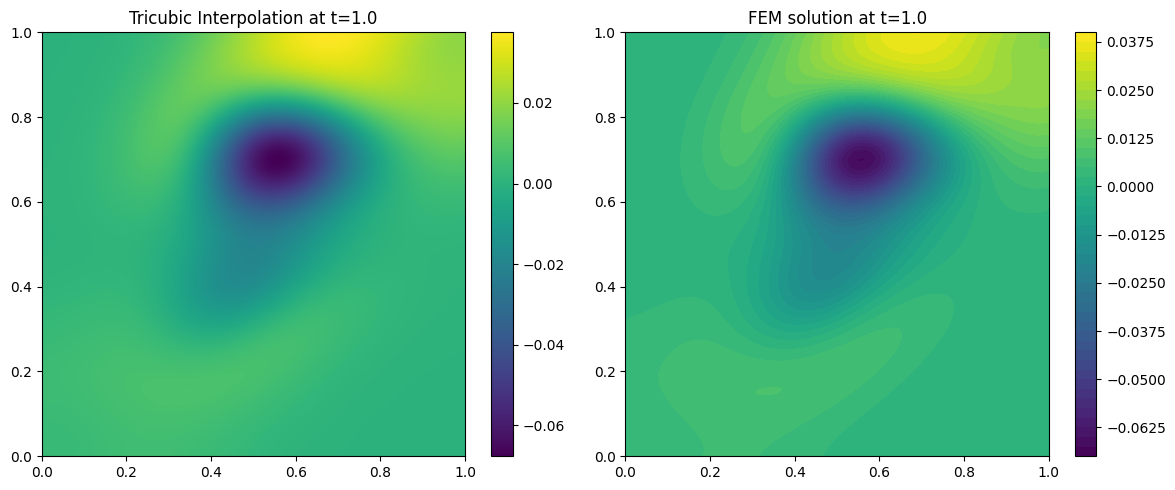

In [30]:
# Interpolate at fixed z (t = 0.5)
z0 = 0.5
xi = np.linspace(0, 1, 200)
yi = np.linspace(0, 1, 200)
Xi, Yi = np.meshgrid(xi, yi) # indexing='ij'
Fi = np.zeros_like(Xi)
for ii in range(Xi.shape[0]):
    for jj in range(Xi.shape[1]):
        Fi[ii, jj] = tricubic_interp(x, y, z, G_theta_3, Mx_t3, My_t3, Mz_t3, Xi[ii, jj], Yi[ii, jj], z0)


# Plotting the interpolated and true results as 2D heatmaps

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Interpolated heatmap
im0 = axes[0].imshow(Fi.T, extent=(xi[0], xi[-1], yi[0], yi[-1]), origin='lower', aspect='auto', cmap='viridis')
axes[0].set_title('Tricubic Interpolation at t=1.0')
#axes[0].set_xlabel('x')
#axes[0].set_ylabel('y')
fig.colorbar(im0, ax=axes[0], orientation='vertical')

# True heatmap
im1 = axes[1].tricontourf(tri, sensitivities[2,:,100], levels=50)
axes[1].set_title("FEM solution at t=1.0")
#axes[1].set_xlabel('x')
#axes[1].set_ylabel('y')
fig.colorbar(im1, ax=axes[1], orientation='vertical')

plt.tight_layout()
plt.show()

# Compute the FIM and Psi

In [31]:
def regularize_fim(FIM, lambda_reg=1e-6):
    """Regularize the Fisher Information Matrix to ensure positive definiteness."""
    n = FIM.shape[0]
    FIM_reg = FIM + lambda_reg * np.eye(n)
    return FIM_reg

In [32]:
def compute_FIM(sensor_position, time_grid, num_params = 5):
    """
    function for computing FIM:
    sensor_position: (N+1,2)
    time_grid: (N+1,) where N is an even number for Simpson's rule.

    Returns: FIM of shape (num_params, num_params)
    """
    nt = time_grid.shape[0]
    S_list = []

    # Interpolate sensitivities for sensor curve
    for param in range(num_params):

        Mx, My, Mz = list_sec_derivatives[param]
        S_param = np.zeros(nt)

        for i in range(nt):
            xx, yy = sensor_position[i]
            tt = time_grid[i]
            S_param[i] = tricubic_interp(x, y, z, G_theta[param], Mx, My, Mz, xx, yy, tt)

        S_list.append(S_param.copy()) # sensitivities at each time step

    S = np.stack(S_list, axis = -1) # shape (N+1, num_params)

    FIM = np.zeros((num_params, num_params))

    # Compute only upper triangle
    for i in range(num_params):
        for j in range(i, num_params):
            integrand = S[:, i] * S[:, j]
            FIM[i, j] = simpson(integrand, time_grid)
            if i != j:
                FIM[j, i] = FIM[i, j]  # Fill symmetric entry


    return regularize_fim(FIM)

In [33]:
def Psi(FIM):
    # Computes -ln(det(FIM)) for a symmetric positive definite FIM
    L = np.linalg.cholesky(FIM)
    return - 2 * np.sum(np.log(np.diag(L)))

In [34]:
def Psi_stable(FIM):
    # Computes -ln(det(FIM)) for a symmetric positive definite FIM
    # slogdet is a numerically stable way
    sign, logdet = np.linalg.slogdet(FIM)

    if sign <= 0:
        raise ValueError("FIM is not positive definite, log-determinant undefined.")

    return -logdet  # -ln(det(FIM))

# Parameterize the sensor curve using cubic splines

In [35]:
# Define the cubic B-spline function g(τ)
def g_bspline(tau):
    tau = abs(tau)
    if tau < 1:
        return (2/3) - tau**2 + 0.5 * tau**3
    elif tau < 2:
        return (1/6) * (2 - tau)**3
    else:
        return 0.0

# Basis function φ_i(t) = g(t/h - i + 2)
def phi_i(t, i, h):
    return g_bspline(t / h - i + 2)


def trajectory(t, omega, h):
    """
    Compute the point x(t) ∈ R^2 using cubic B-spline coefficients.
        t : float
            Time at which to evaluate the curve.
        omega : ndarray of shape (2, p)
            Coefficients omega[0, :] for x1(t), omega[1, :] for x2(t).
        h : float
            Step size in time: h = tf / (p - 3)
    Returns:
        x(t) as a NumPy array of shape (2,)
    """
    p = omega.shape[1]
    x = np.zeros(2)
    for i in range(p):
        phi = phi_i(t, i, h)
        x[0] += omega[0, i] * phi
        x[1] += omega[1, i] * phi
    return x

# Compute Performance index J(s_0,u)

In [36]:
# Parameters for evaluating sensor trajectory
# p = 40  # number of basis functions (p > 3)
# h = 1.0 / (p - 3)


def J(u_coeffs, time_axis, p):
    """
    Compute the performance index of the current (s0,u):

      u_coeffs: spline coefficients of sensor curve u, shape (2, p)
      time_axis: time devision, shape (N+1,)
          where N is an even number for Simpson's rule (in computing FIM)
      p: number of basis functions for sensor curve (p > 3)

    Return J(s0, u) = Psi(M(s(s0, u))) + a/2|d/dt u|^2
    """
    h = 1.0 / (p - 3)

    # Evaluate trajectory
    sensor_position = np.array([trajectory(t, u_coeffs, h) for t in time_axis]) # shape (N+1, 2)

    # compute FIM
    FIM = compute_FIM(sensor_position, time_axis)

    return Psi_stable(FIM)

# The Matrix Gradient and Xsi

In [37]:
def Psi_matrix_gradient(M):
    """
    Compute the gradient of -log(det(M)) wrt M,
      where M is a symmetric positive definite matrix.
    Return -M^{-1}
    """
    # Solve M X = I → X = M^{-1} using Cholesky decomposition
    identity = np.eye(M.shape[0])
    M_inv = cho_solve(cho_factor(M), identity)
    return -M_inv

In [38]:
def computing_Xsi_vectorized(sensor_position, time_grid, list_sec_derivatives, G_theta, x, y, z):
    """
    Compute the matrix of gradients of sensitivities at sensor positions.

    sensor_position : ndarray, shape (nt, 2)
        Sensor positions at each time step.
    time_grid : ndarray, shape (nt,)
        Time grid.
    list_sec_derivatives : list of tuples
        Each tuple (Mx, My, Mz) for each parameter.
    G_theta : list of ndarray
        Function values for each parameter, matching tricubic_interp.
    x, y, z : ndarray
        Grid points for tricubic interpolation.

    Returns:
    Xsi : ndarray, shape (nt, num_params, num_params, 2)
        Gradient matrices of sensitivities at each time step.
    """
    nt = time_grid.shape[0]
    num_params = len(list_sec_derivatives)

    # Precompute sensitivities S and partial derivatives
    S = np.zeros((nt, num_params))
    S_partial_x = np.zeros((nt, num_params))
    S_partial_y = np.zeros((nt, num_params))

    for param in range(num_params):
        Mx, My, Mz = list_sec_derivatives[param]
        for t in range(nt):
            xx, yy = sensor_position[t]
            tt = time_grid[t]
            S[t, param] = tricubic_interp(x, y, z, G_theta[param], Mx, My, Mz, xx, yy, tt)
            S_partial_x[t, param] = partial_x(x, y, z, G_theta[param], Mx, xx, yy, tt)
            S_partial_y[t, param] = partial_y(x, y, z, G_theta[param], Mx, xx, yy, tt)

    # Compute Xsi using broadcasting
    Xsi = np.zeros((nt, num_params, num_params, 2))
    for i in range(num_params):
        for j in range(i, num_params):
            Xsi[:, i, j, 0] = S[:, i] * S_partial_x[:, j] + S[:, j] * S_partial_x[:, i]
            Xsi[:, i, j, 1] = S[:, i] * S_partial_y[:, j] + S[:, j] * S_partial_y[:, i]
            if i != j:
                Xsi[:, j, i, 0] = Xsi[:, i, j, 0]
                Xsi[:, j, i, 1] = Xsi[:, i, j, 1]

    return Xsi


# Compute the Frechet derivative δJ(s0,u;δs0,δu)

In [39]:
def frechet_deriv_vectorized(u_coeffs, time_axis, p, num_params=5):
    """
    Compute the Frechet derivative of J(u) w.r.t u_coeffs (without regularization)
    in a vectorized form.

    Returns:
        c1, c2 : arrays of shape (p,)
    """
    h = 1.0 / (p - 3)
    nt = len(time_axis)

    # Evaluate trajectory
    sensor_position = np.array([trajectory(t, u_coeffs, h) for t in time_axis])  # shape (nt, 2)

    # Compute FIM
    FIM = compute_FIM(sensor_position, time_axis)
    c = Psi_matrix_gradient(FIM)  # shape (num_params, num_params)

    # Compute Xsi
    Xsi = computing_Xsi_vectorized(sensor_position, time_axis, list_sec_derivatives, G_theta, x, y, z)  # (nt, num_params, num_params, 2)

    # Precompute basis functions for all time steps and basis indices
    Phi = np.zeros((nt, p))
    for k in range(p):
        Phi[:, k] = np.array([phi_i(t, k, h) for t in time_axis])  # shape (nt,)

    # Initialize derivatives
    c1 = np.zeros(p)
    c2 = np.zeros(p)

    # Vectorized computation over time
    for i in range(num_params):
        for j in range(num_params):
            # Multiply Xsi[:, i, j, :] with Phi and integrate over time
            integrals_1 = np.trapezoid(Xsi[:, i, j, 0][:, None] * Phi, x=time_axis, axis=0)  # shape (p,)
            integrals_2 = np.trapezoid(Xsi[:, i, j, 1][:, None] * Phi, x=time_axis, axis=0)  # shape (p,)

            c1 += c[i, j] * integrals_1
            c2 += c[i, j] * integrals_2

    return c1, c2


In [40]:
def linear_solver(J, u_0, p, solver=None):
    """
    Solve the linear problem min J(u_0)^T u:
      J: Frechet derivative at u_0, shape (2, p)
      u_0: spline coefficients of sensor curve u_0, shape (2, p)
      p: number of basis functions for sensor curve (p > 3)

    Return optimal decent direction  # shape (p,)
    """
    # Define variable
    du = cp.Variable(p) # cp.Variable(2*p)

    # Objective
    objective = cp.Minimize(du @ J)

    # Constraints
    constraints = [
        du + u_0 >= 0.0,
        du + u_0 <= 1.0
    ]

    # Problem definition and solve
    prob = cp.Problem(objective, constraints)
    prob.solve()
        # Solve
    try:
        prob.solve(solver=solver)
    except Exception as e:
        return None, f"Solver failed: {str(e)}", None


    return du.value, prob.status, prob.value

# Optimization Loop

In [41]:
num_epochs = 1000
time_axis = np.linspace(0,1, 200+1)

norm_bound_u = 0.05        # control magnitude of variation
p = 8                      # number of basis functions (must be > 3)
h = 1.0 / (p - 3)

# initialize coefficients within the domain

u_coeffs = np.ones([2, p])*0.5

np.random.seed(10)  # fix seed for reproducibility
margin = 0.05  # keep trajectory inside [0.05, 0.95]
#u_coeffs = margin + (1 - 2*margin) * np.random.rand(2, p)

initial_coeffs = u_coeffs.copy()


In [42]:
# Optimization Loop
for i in range(num_epochs + 1):

    # compute Frechet derivative
    c1, c2 = frechet_deriv_vectorized(u_coeffs, time_axis, p, num_params=5)  # shape (p,), (p,)

    # solve linear problem
    du_coeffs_1, Status1, value1 = linear_solver(c1, u_coeffs[0,:], p)
    du_coeffs_2, Status2, value2 = linear_solver(c2, u_coeffs[1,:], p)

    # combine updates
    du_coeffs = np.vstack([du_coeffs_1, du_coeffs_2])  # shape (2, p)

    # inverse time decay for norm_bound_u
    norm_bound_u_t = norm_bound_u / (1 + 0.01 * i)

    # normalize update
    norm_du = np.linalg.norm(du_coeffs.reshape(2*p))
    if norm_du > 0:
        du_coeffs *= norm_bound_u_t / norm_du

    # update coefficients
    u_coeffs += du_coeffs

    # log progress
    if i % 50 == 0:
        performance_index = J(u_coeffs, time_axis, p)
        print(f"Step {i+1}/{num_epochs} | Status: {Status1}, {Status2} | dJ: {value1 + value2:.6f} | J: {performance_index:.6f}")


Step 1/1000 | Status: optimal, optimal | dJ: -28.171205 | J: 44.099847
Step 51/1000 | Status: optimal, optimal | dJ: -6.490123 | J: 37.056234
Step 101/1000 | Status: optimal, optimal | dJ: -2.805359 | J: 36.327607
Step 151/1000 | Status: optimal, optimal | dJ: -3.207921 | J: 36.241428
Step 201/1000 | Status: optimal, optimal | dJ: -1.476738 | J: 36.217824
Step 251/1000 | Status: optimal, optimal | dJ: -1.798888 | J: 36.164589
Step 301/1000 | Status: optimal, optimal | dJ: -3.063614 | J: 36.142433
Step 351/1000 | Status: optimal, optimal | dJ: -1.048545 | J: 36.118591
Step 401/1000 | Status: optimal, optimal | dJ: -1.624289 | J: 36.093884
Step 451/1000 | Status: optimal, optimal | dJ: -1.051008 | J: 36.082841
Step 501/1000 | Status: optimal, optimal | dJ: -1.027094 | J: 36.077997
Step 551/1000 | Status: optimal, optimal | dJ: -1.257208 | J: 36.054915
Step 601/1000 | Status: optimal, optimal | dJ: -1.999530 | J: 36.041423
Step 651/1000 | Status: optimal, optimal | dJ: -1.694278 | J: 36.0

# Visualize

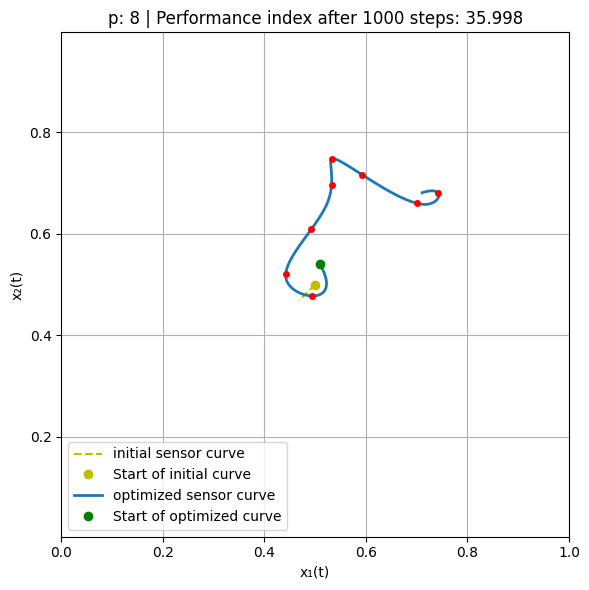

In [43]:
# sensor curve evaluation
traj_orig = np.array([trajectory(t, u_coeffs, h) for t in time_axis]) # shape (201, 2)
initial_curve = np.array([trajectory(t, initial_coeffs, h) for t in time_axis])

# Mark specific times with little dots
mark_times = np.linspace(0, 1, 10)[:-1] # 0.1, 0.2, ..., 1.0
indices = [np.argmin(np.abs(time_axis - mt)) for mt in mark_times]

# Plot
plt.figure(figsize=(6, 6))

plt.plot(initial_curve[:190, 1], initial_curve[:190, 0], 'y--', label="initial sensor curve")
plt.plot(initial_curve[0, 1], initial_curve[0, 0], 'yo', label="Start of initial curve")

plt.plot(traj_orig[:190, 1], traj_orig[:190, 0], label="optimized sensor curve", linewidth=2)
plt.plot(traj_orig[indices, 1], traj_orig[indices, 0], 'ro', markersize=4) # , label= "t = 0.1,0.2,...,0.9"
plt.plot(traj_orig[0, 1], traj_orig[0, 0], 'go', label="Start of optimized curve")

plt.title(f"p: {p} | Performance index after 1000 steps: {performance_index:.3f}")
plt.xlabel("x₁(t)")
plt.ylabel("x₂(t)")

plt.axis("equal")
plt.xlim(0, 1)  # restrict x to [0, 1]
plt.ylim(0, 1)  # restrict y to [0, 1]

plt.grid(True)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()